# Brain tumor using wrsk

In [1]:
library("evaluomeR")
library("cancerclass")
library("devtools")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("ggforce")

#devtools::install_github("brodsa/wrsk")
library("wrsk")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

In [2]:
getRversion()
packageVersion("wrsk")

[1] '4.4.1'

[1] '0.1.0'

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("BrainTumor200.RData")
dataset = BrainTumor200
head(dataset)
unique(dataset$Description)
set.seed(13606)

,Description,X224588_at,X201909_at,X229012_at,X210033_s_at,X236448_at,X240065_at,X206018_at,X225165_at,X220156_at,⋯,X206306_at,X203649_s_at,X206785_s_at,X1563933_a_at,X238603_at,X205751_at,X210271_at,X228347_at,X232720_at,X209138_x_at
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1214834,ependymoma,1.678130,3.644194,3.820705,3.735552,1.172587,3.624207,1.794471,3.691314,3.589067,⋯,3.596530,1.873599,2.146811,3.110174,1.524128,2.563318,1.450476,1.880268,1.737017,1.776431
GSM1214835,ependymoma,3.767506,1.667500,3.224272,3.566060,3.134809,3.381327,3.608933,3.828011,3.315655,⋯,1.716341,1.825732,2.149566,1.619617,1.601342,2.726899,2.637962,1.991922,1.788192,2.720051
GSM1214836,ependymoma,1.676252,3.747256,3.456146,3.642242,1.194883,3.520656,1.797164,3.463318,3.227379,⋯,3.431167,2.897142,2.983751,1.608201,1.587031,2.585998,1.449467,1.815894,1.748981,1.783816
GSM1214837,ependymoma,3.792194,1.636888,3.823623,3.786311,1.168471,3.498731,3.818550,2.747462,3.578139,⋯,1.943356,1.839781,2.128098,1.537581,3.151399,3.113747,1.424955,1.906251,3.647694,2.645952
GSM1214838,ependymoma,3.809949,1.639904,3.561411,1.590063,2.933787,2.997341,1.648297,3.624553,3.551927,⋯,3.594693,2.148758,2.130709,3.167416,1.614435,1.762541,1.429500,1.849851,1.719865,1.758591
GSM1214839,ependymoma,1.740624,3.700109,3.893310,3.761085,1.288353,3.745520,1.841266,3.714091,3.746951,⋯,3.263901,1.930619,2.309651,1.871377,1.540925,1.773522,1.461576,1.901027,1.799332,1.794916


[1] "ependymoma"            "glioblastoma"          "medulloblastoma"      
[4] "pilocytic astrocytoma"

In [4]:
level_mapping <- c("ependymoma" = 1, "glioblastoma" = 2, "medulloblastoma" = 3, "pilocytic astrocytoma" = 4)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(dataset["Description"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
[112] 4 4 4 4 4 4

# WRSK <a class="anchor" id="clest"></a>
Execution of Clest over the previous dataset.

In [5]:
k.range = c(3,10)
#s = 11.2112753007614
s = 10.7925809689086
gap_stats = as.numeric(length(k.range[1]:k.range[2]))

In [6]:
calculate_wbcss = function(data, k, s, alpha) {
    set.seed(13606)
    result = suppressWarnings(wrsk(data, k, s, iteration = 15))
    return(sum(result$WBCSS))
}

calculate_gap_statistic = function(data, k.range, s, alpha) {
    wbcss_values = numeric(length(k.range[1]:k.range[2]))
    wbcss_ref_values = numeric(length(k.range[1]:k.range[2]))
    
    for (k in k.range[1]:k.range[2]) {
        # Calculate WBCSS for original data
        wbcss_values[k - k.range[1] + 1] = calculate_wbcss(data, k, s, alpha)
        
        # Permute the data and calculate WBCSS for the permuted dataset
        permuted_data = data[sample(nrow(data)), ]
        wbcss_ref_values[k - k.range[1] + 1] = calculate_wbcss(permuted_data, k, s, alpha)
    }
    
    # Compute Gap Statistic (log(WBCSS_ref) - log(WBCSS))
    gap_stat = log(wbcss_ref_values) - log(wbcss_values)
    
    return(gap_stat)
}

find_optimal_k = function(gap_stat, k.range) {
  optimal_k_index = which.max(gap_stat)
  optimal_k = (k.range[1]:k.range[2])[optimal_k_index]
  return(optimal_k)
}

In [7]:
dataset_matrix = as.matrix(dataset[, -1])
rownames(dataset_matrix) = NULL
gap_stat = calculate_gap_statistic(dataset_matrix, k.range, s, alpha)

print(gap_stat)

[1]  0.000000000  0.000000000 -0.001376809  0.013174621  0.016547852
[6]  0.017385117  0.001743957 -0.002447206


In [8]:
# Find the optimal k
optimal_k = as.numeric(find_optimal_k(gap_stat, k.range))
print(paste("The optimal k is:", optimal_k))

[1] "The optimal k is: 8"


In [9]:
set.seed(13606)
result = suppressWarnings(wrsk(dataset_matrix, optimal_k, s, iteration = 15))
predicted = result$clusters
predicted

[1] 2 4 8 4 8 2 4 2 8 8 8 4 2 4 2 2 4 8 8 2 8 8 4 2 8 2 2 2 8 2 2 4 2 2 8 2 7
 [38] 8 8 8 4 8 3 4 2 2 7 7 5 5 5 7 3 7 7 7 5 3 7 3 7 4 7 7 7 7 5 5 7 5 5 5 7 7
 [75] 5 5 5 5 5 7 1 1 1 6 1 1 6 1 1 6 6 6 1 6 1 1 6 6 6 6 1 6 3 5 3 3 3 3 5 3 3
[112] 3 3 5 3 3 3

In [10]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix <- dataset[, !names(dataset) %in% "Cluster"]
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 27



Warning message:
"ggrepel: 113 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


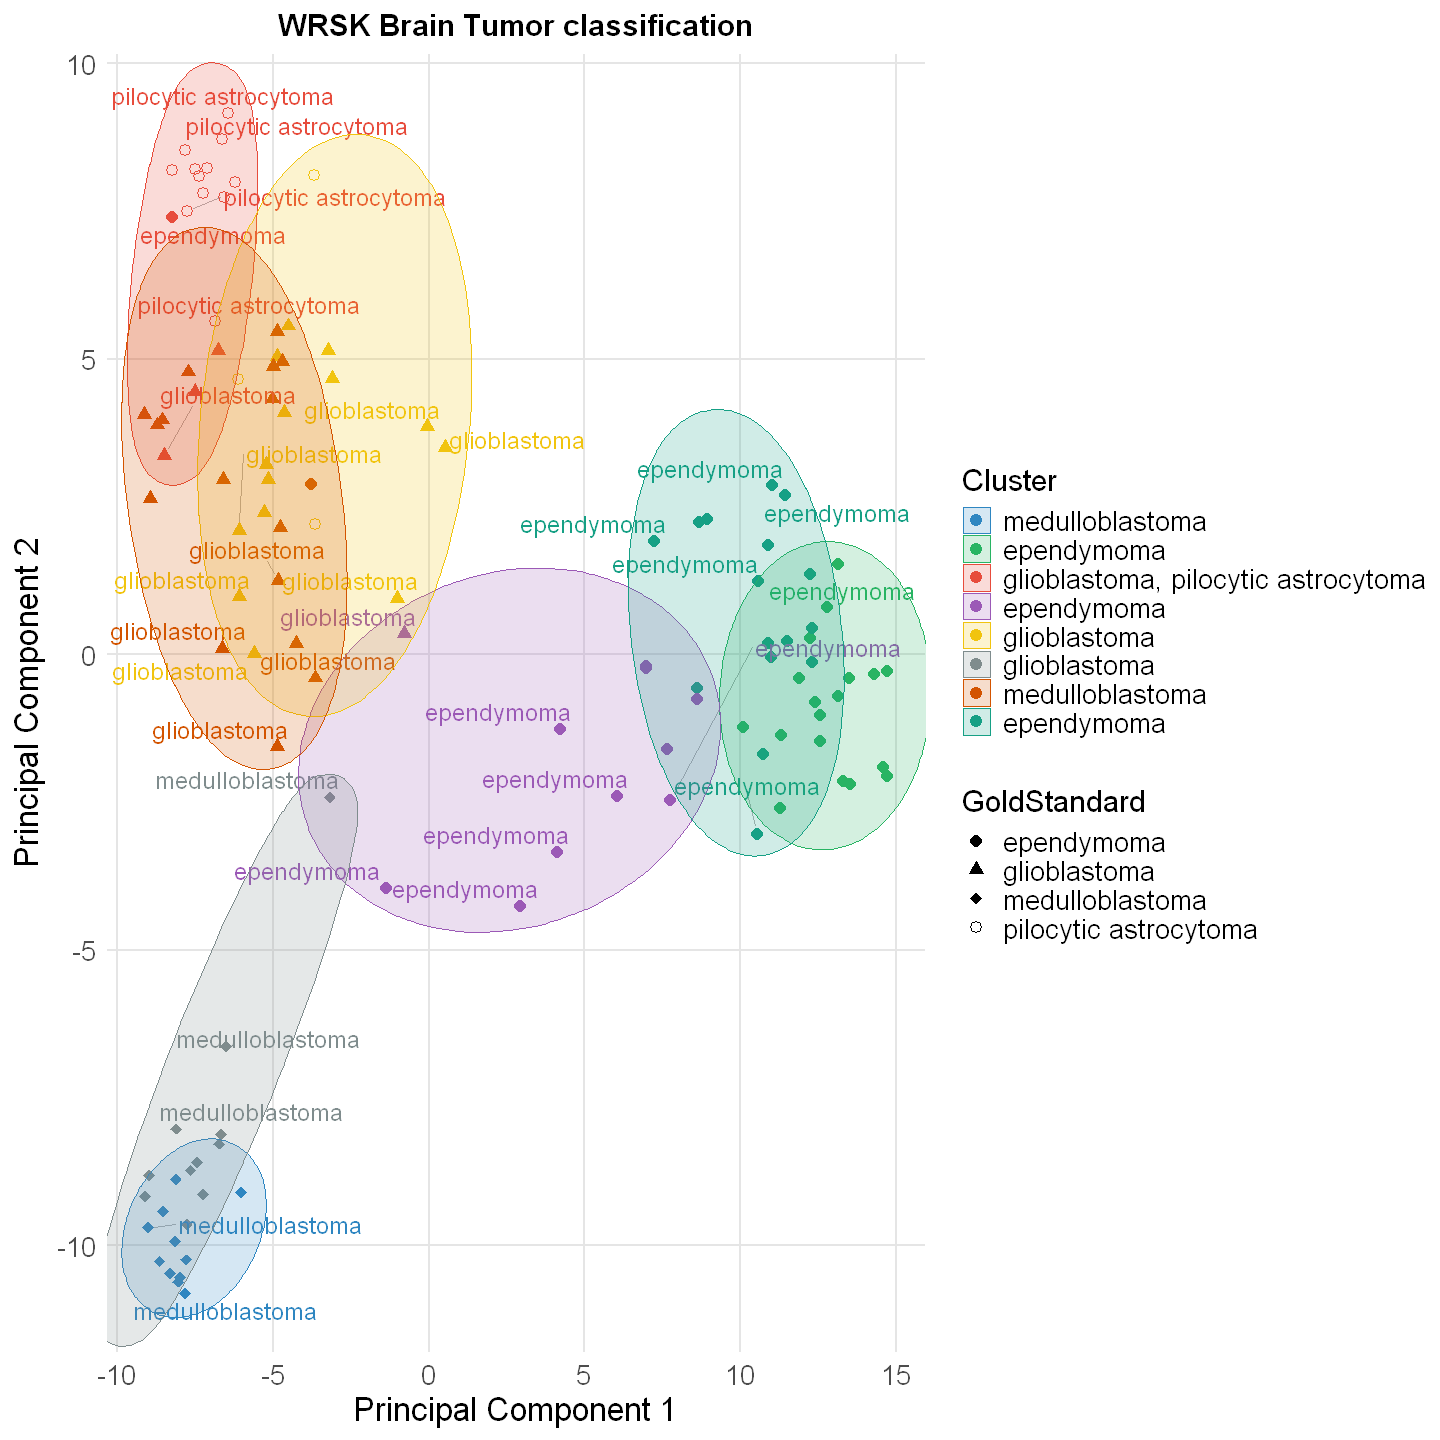

In [21]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = Description,
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "ependymoma" ~ 16,
      Letter == "glioblastoma" ~ 17,
      Letter == "medulloblastoma" ~ 18,
      Letter == "pilocytic astrocytoma" ~ 21,
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)


Warning message:
"ggrepel: 113 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


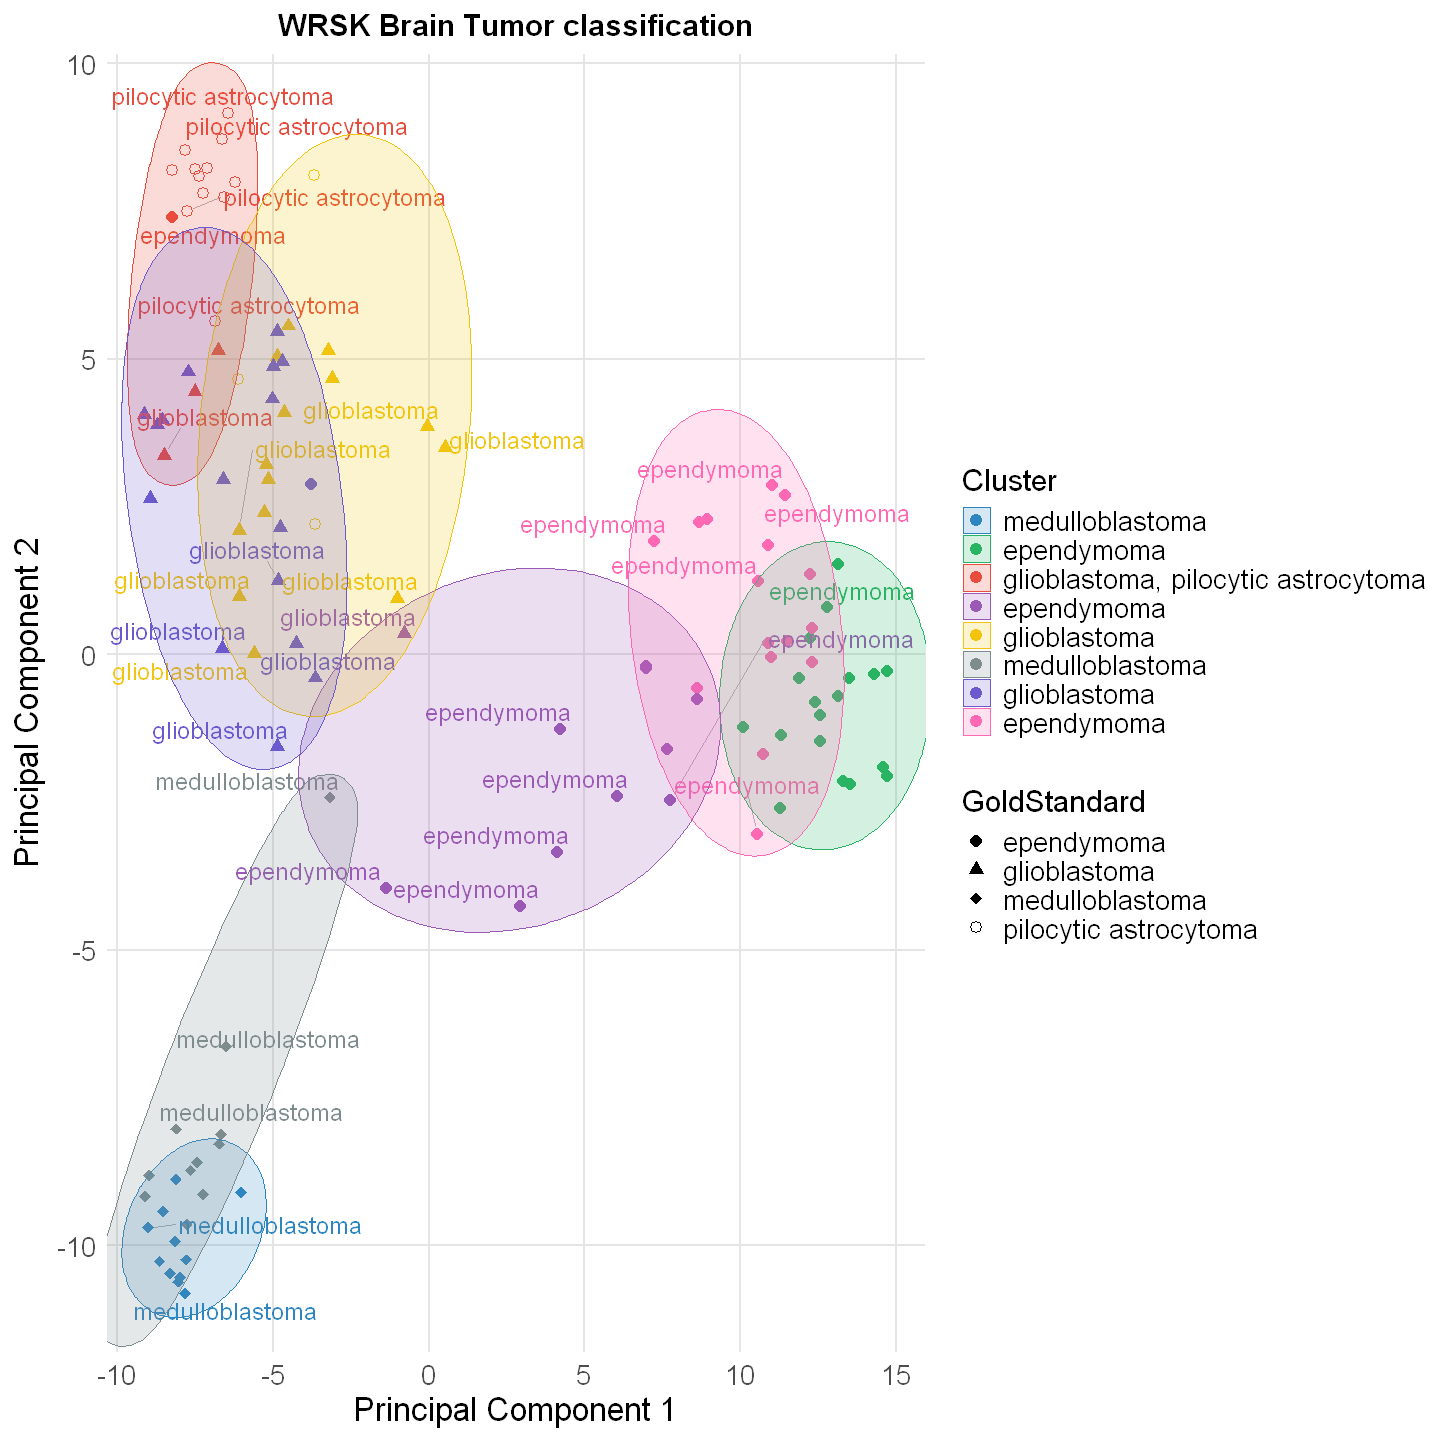

In [35]:

cluster_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D",
                    "#6A5ACD", "#FF69B4")

cluster_shapes <- c(16, 17, 18, 21, 22, 23, 24)
cluster_labels <- c("medulloblastoma", "ependymoma", "glioblastoma, pilocytic astrocytoma", "ependymoma", "glioblastoma",
                    "medulloblastoma", "glioblastoma", "ependymoma")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 5,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 5,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  geom_mark_ellipse(aes(group = Cluster, fill = Cluster, label = NULL), alpha = 0.2) +
  labs(
    title = "WRSK Brain Tumor classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = unique(pca_df$Description)) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels) +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


In [40]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
names(sensitivity_table) = unique(dataset$Description)
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,ependymoma,glioblastoma,medulloblastoma,pilocytic astrocytoma
,<chr>,<chr>,<chr>,<chr>
Sensitivity. (%),39,47,50,80


[1] "(39,47,50,80)"

In [39]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))
# SEN (39,50,50,87)
# CER 19.20

[1] "CER: 19.75%"


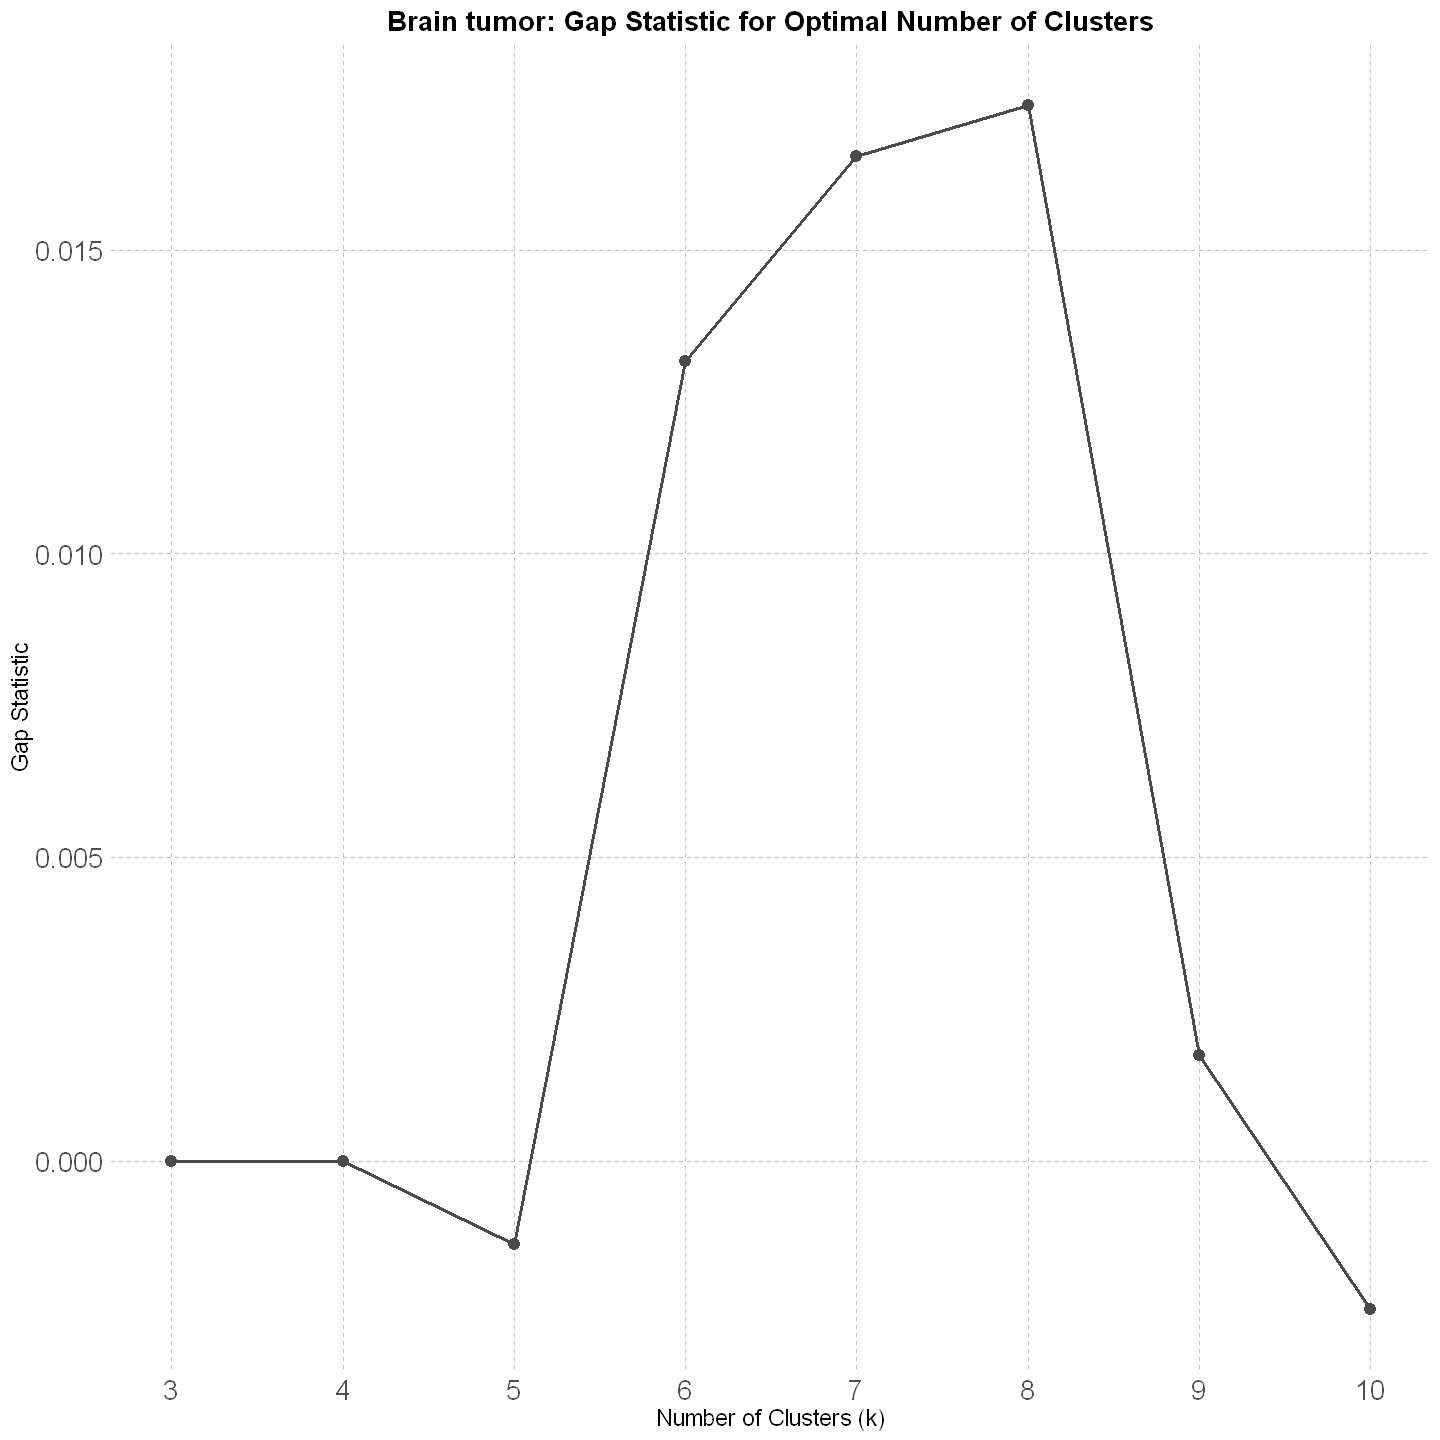

In [34]:
gap_data <- data.frame(
  k = k.range[1]:k.range[2],
  gap_stat = gap_stat
)

ggplot(gap_data, aes(x = k, y = gap_stat)) +
  geom_point(color = "#4B4B4B", size = 3) +
  geom_line(color = "#4B4B4B", size = 1) +
  #geom_hline(yintercept = max(gap_stat), color = "#E74C3C", linetype = "dashed", size = 1.2) +  # Red dashed line at max gap statistic
  #annotate("text", x = optimal_k, y = max(gap_stat), label = paste("Optimal k =", optimal_k), vjust = -0.5, color = "#E74C3C", size = 4) +  # Label for optimal k
  labs(
    title = "Brain tumor: Gap Statistic for Optimal Number of Clusters",
    x = "Number of Clusters (k)",
    y = "Gap Statistic"
  ) +
  scale_x_continuous(breaks = k.range[1]:k.range[2]) +  # Set x-axis ticks to show all values in the range
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    panel.grid.minor = element_blank()
  )